In [1]:
import datetime
import tarfile
import json
import bz2

## Filtering tweets from monthly .tar files

In [20]:
#keywords to filter the tweets
keywords=['gmo','gmos','gm food','gm foods','transgenic', 'transgenics','genetically-modified','genetically modified']

# initializing array which will hold the filtered tweets
filteredTweets=[]


# opening the tar file
with tarfile.open('data/TweetDS.tar', 'r') as tar:
    
    # iterating through all files and directories
    for member in tar.getmembers():
        
        #skipping directories
        if member.isdir():
            continue
        
        #looking for the target files json.bz2
        if member.name.endswith('.json.bz2'):
            
            # extracting each file
            file = tar.extractfile(member)
         
            #reading in and decompressing the file
            noBz2 = bz2.decompress(file.read()).decode('utf-8')
            
            # handling each tweet to find the match
            for line in noBz2.splitlines():
                
                #each line is one tweet in json format, therefore loading line by line
                tweet = json.loads(line)

                # making sure the tweet has the fields 'text' and 'created_at'. If not they'll be skipped
                if 'text' not in tweet or 'created_at' not in tweet or tweet['user']['lang'] != 'en':
                    continue

                # Skipping retweets
                if tweet['text'].startswith('RT') and tweet.get('retweeted_status') is not None:
                    continue
                
                # storing fields if present
                tweetTxt = tweet['text']
                created_at = tweet['created_at']

                # Searching matches in text, splitting by words, lower case like keywords
                if any(keyword in tweetTxt.lower().split() for keyword in keywords):                
                    # Add the matching tweet to the list
                    filteredTweets.append({
                        'text': tweetTxt,
                        'created_at': created_at
                    })
                    

                    
#writting the fields from matching tweets to a json output file
with open('myTweets.json', 'w') as output:
    json.dump(filteredTweets, output)


In [2]:
from pyspark.sql.types import *
from pyspark.sql.functions import udf
from pyspark.sql.types import TimestampType

In [3]:
sc

<SparkContext master=local[*] appName=PySparkShell>

### Loading data files to pyspark

In [4]:
#funtion to convert to time stamp with udf
def parseDate(date_str):
    return datetime.datetime.strptime(date_str, '%a %b %d %H:%M:%S %z %Y')

parse_date_udf= udf(parseDate, TimestampType())

#reading in the monthly json files
tweets= spark.read.json('hdfs://localhost:9000/user1/tweet*.json')

# applying udf to column
tweets= tweets.withColumn('created_at', parse_date_udf(tweets['created_at']))

#sorting by timestamp
tweets= tweets.orderBy('created_at')

tweets.printSchema();tweets.show()

root
 |-- created_at: timestamp (nullable = true)
 |-- text: string (nullable = true)



+-------------------+--------------------+
|         created_at|                text|
+-------------------+--------------------+
|2012-01-02 20:09:42|USDA has settled ...|
|2012-01-03 02:41:36|Sounds INSANE. GM...|
|2012-01-03 06:57:08|Petition: Tell th...|
|2012-01-03 12:30:19|Mandatory GMO foo...|
|2012-01-03 14:11:44|http://t.co/TI9oL...|
|2012-01-03 16:10:27|Want to learn mor...|
|2012-01-03 17:53:55|Safety assessment...|
|2012-01-03 18:30:38|GMO labeling effo...|
|2012-01-03 20:04:57|Leaked: US to Sta...|
|2012-01-04 00:22:12|Leaked: US to Sta...|
|2012-01-04 13:37:46|@IPIMCIMCIM  GMOs...|
|2012-01-05 02:42:31|@Kaybaebaeeee gmo...|
|2012-01-05 06:10:28|Apel ws. legislac...|
|2012-01-05 09:36:54|Woman files class...|
|2012-01-05 16:14:15|Leaked: US to Sta...|
|2012-01-05 17:42:20|@harjxo GMO twidd...|
|2012-01-05 19:42:18|@songbirdtiff Yup...|
|2012-01-05 21:07:46|Label GMO food ca...|
|2012-01-06 00:21:13|Transgenic Trees ...|
|2012-01-06 01:31:14|Woman Sues Frito-...|
+----------

In [5]:
# number of rows
tweets.count()

3384

In [6]:
#sample
tweets.take(1)

[Row(created_at=datetime.datetime(2012, 1, 2, 20, 9, 42), text='USDA has settled upon a superb solution: let the GMO industry conduct its own environmental impact tests. http://t.co/Ed5BbDRb')]

### Dates without tweets

In [7]:
from pyspark.sql.functions import min, max, date_format, expr, hour
from pyspark.sql import functions as F
from pyspark.sql.types import DateType

In [9]:

# oldest and latest dates in df
oldestDate= tweets.select(min('created_at')).first()[0].date()
latestDate= tweets.select(max('created_at')).first()[0].date()

#converting dates to Unix timestamps -> int() cannot be datetime.date
oldestDate= int(oldestDate.strftime("%s"))
latestDate= int(latestDate.strftime("%s"))


#generating the list of dates. 86400 s/day
timeRange= spark.range(start=oldestDate, end=latestDate, step=86400).selectExpr("to_date(from_unixtime(id)) as date")



#Listing missing dates with anti-join between the date range and the 'created_at' column. 
missingDates= timeRange.join(tweets, timeRange.date == tweets.created_at.cast(DateType()), 'leftanti') # leftanti selects the rows from the left df that do not have a matching key from the right df


print("Count of missing dates:",missingDates.count());missingDates.show()

Count of missing dates: 1
+----------+
|      date|
+----------+
|2012-02-05|
+----------+



#### Checking full hours per day without tweets

In [13]:
from pyspark.sql.functions import collect_list

In [14]:
minDate= tweets.selectExpr("min(created_at)").first()[0]
maxDate= tweets.selectExpr("max(created_at)").first()[0]


minTimestamp= int(minDate.timestamp())
maxTimestamp= int(maxDate.timestamp())

allHours= spark.range(minTimestamp, maxTimestamp, 3600).select(expr("timestamp_seconds(id)").alias('hour'))




tweetsWithHour= tweets.withColumn('hour_of_day', hour('created_at'))


tweetHours= tweetsWithHour.groupBy('hour_of_day').agg(collect_list('hour_of_day').alias('hours'))

allHours.join(tweetHours, allHours.hour == tweetHours.hour_of_day, 'left')


AnalysisException: cannot resolve '(hour = hour_of_day)' due to data type mismatch: differing types in '(hour = hour_of_day)' (timestamp and int).;
'Join LeftOuter, (hour#178 = hour_of_day#180)
:- Project [timestamp_seconds(id#176L) AS hour#178]
:  +- Range (1325534982, 1356574202, step=3600, splits=Some(1))
+- Aggregate [hour_of_day#180], [hour_of_day#180, collect_list(hour_of_day#180, 0, 0) AS hours#188]
   +- Project [created_at#12, text#8, hour(created_at#12, Some(Europe/Dublin)) AS hour_of_day#180]
      +- Sort [created_at#12 ASC NULLS FIRST], true
         +- Project [parseDate(created_at#7) AS created_at#12, text#8]
            +- Relation [created_at#7,text#8] json


## Basic plots

In [80]:
import matplotlib.pyplot as plt
from pyspark.sql.functions import dayofweek, month, hour, count

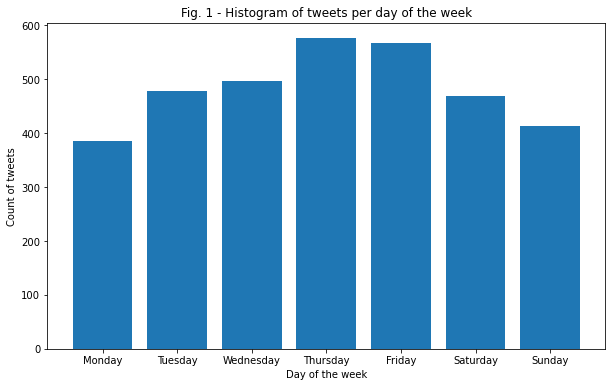

In [98]:

tweets= tweets.withColumn('day_of_week', dayofweek('created_at'))

tweetCounts = tweets.groupBy('day_of_week').agg(count('*').alias('count'))


dayLabels = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']


plt.figure(figsize=(10, 6))
plt.bar(tweetCounts.toPandas()['day_of_week'], tweetCounts.toPandas()['count'])
plt.xlabel('Day of the week')
plt.ylabel('Count of tweets')
plt.title('Fig. 1 - Histogram of tweets per day of the week')
plt.xticks(range(1, 8), dayLabels)
plt.show()

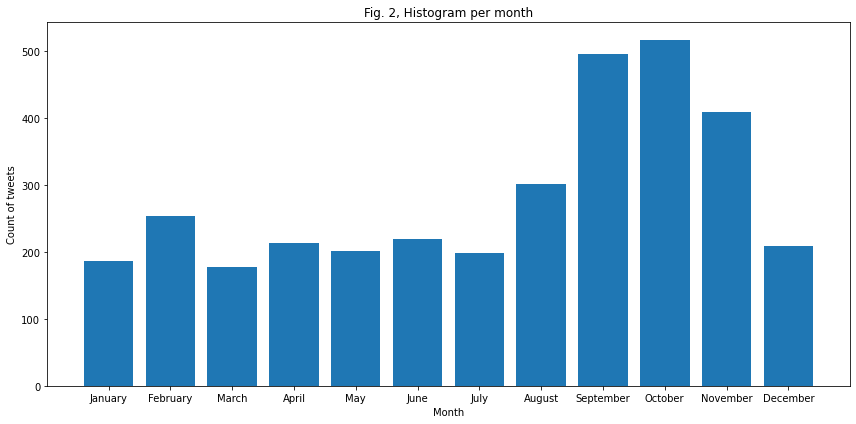

In [109]:
tweets = tweets.withColumn('month', month('created_at'))

tweetCounts = tweets.groupBy('month').agg(count('*').alias('count'))



monthLabels = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']


plt.figure(figsize=(12, 6))
plt.bar(tweetCounts.toPandas()['month'], tweetCounts.toPandas()['count'])
plt.xlabel('Month')
plt.ylabel('Count of tweets')
plt.title('Fig. 2, Histogram per month')
plt.xticks(range(1, 13), monthLabels)
plt.tight_layout()
plt.show()

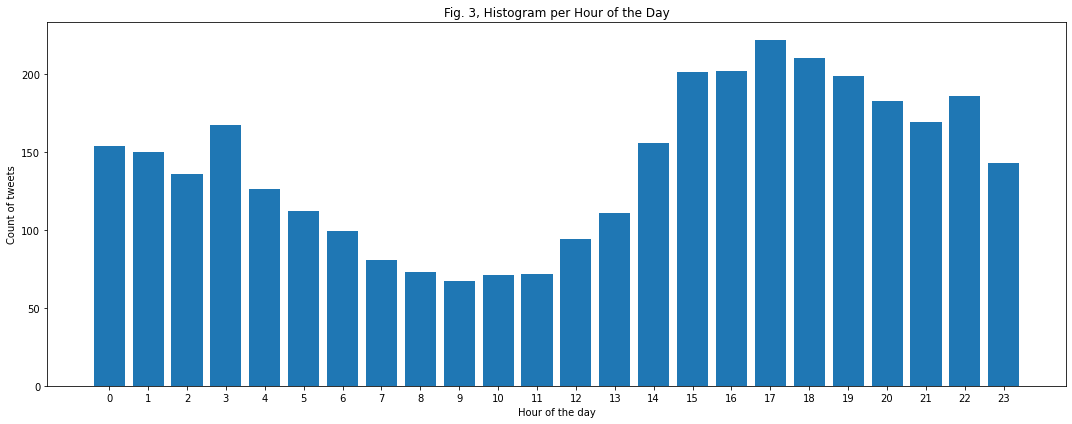

In [122]:
tweets = tweets.withColumn('hour_of_day', hour('created_at'))

tweetCounts = tweets.groupBy('hour_of_day').agg(count('*').alias('count'))


plt.figure(figsize=(15, 6))
plt.bar(tweetCounts.toPandas()['hour_of_day'], tweetCounts.toPandas()['count'])
plt.xlabel('Hour of the day')
plt.ylabel('Count of tweets')
plt.title('Fig. 3, Histogram per Hour of the Day')
plt.xticks(range(24))
plt.tight_layout()
plt.show()

In [15]:
import pandas as pd
import numpy as np
import seaborn as sns
import re
import string
from string import punctuation
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')


import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout
from tensorflow.keras.callbacks import EarlyStopping

ModuleNotFoundError: No module named 'nltk'

In [191]:
!pip install nltk

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 282.0 kB/s eta 0:00:000:00:010:00:01:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 769.7/769.7 KB 74.0 kB/s eta 0:00:0031m73.3 kB/s eta 0:00:01
